In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm.notebook as tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torchvision import datasets
import pip
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix
from IPython.display import SVG, display, clear_output

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*IMAGE TRANSFORMATIONS*

In [ ]:
#calcular la media y la desviacion tipica sobre el conjunto de imagenes 0-1
#Modelos de imagenet están pensados para tomar imagenes de 3 canales
#def apply_image(path):
  #Image.open(path).convert('RGB')
  #ImageDataLoader(loader = apply_image)

  #ImageAugmentation
# -Imagenes : Covid : 1000, Normal 1341, viral 1345 -Image Augmentation

#Modelos a aplicar con transfer learning: -SqueezeNet -MobileNetv2 -ResNet18 -DenseNet201 -VGG19 -WideResnet -ResNext

#Para evaluacion:

#-También aplicar 5-fold cross-validation (accuracy, sensitivity, precision....)

#Optimizador: -SGD con momentum 0.9

In [ ]:
normalize_mean = [0.485,0.456,0.406]
normalize_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(), 
  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
  transforms.Normalize(normalize_mean, normalize_std)
])

In [ ]:
!mkdir -p /my_data/

In [ ]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip
   creating: /my_data/Viral Pneumonia/
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (10).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (100).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1000).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1001).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1002).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1003).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1004).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1005).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1006).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1007).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1008).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1009).png  
 extracting: /my_data/Viral Pneum

In [ ]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/COVID.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/COVID.zip
   creating: /my_data/COVID/
   creating: /my_data/COVID/COVID/
 extracting: /my_data/COVID/COVID (1).png  
 extracting: /my_data/COVID/COVID (10).png  
 extracting: /my_data/COVID/COVID (100).png  
 extracting: /my_data/COVID/COVID (1000).png  
 extracting: /my_data/COVID/COVID (1001).png  
 extracting: /my_data/COVID/COVID (1002).png  
 extracting: /my_data/COVID/COVID (1003).png  
 extracting: /my_data/COVID/COVID (1004).png  
 extracting: /my_data/COVID/COVID (1005).png  
 extracting: /my_data/COVID/COVID (1006).png  
 extracting: /my_data/COVID/COVID (1007).png  
 extracting: /my_data/COVID/COVID (1008).png  
 extracting: /my_data/COVID/COVID (1009).png  
 extracting: /my_data/COVID/COVID (101).png  
 extracting: /my_data/COVID/COVID (1010).png  
 extracting: /my_data/COVID/COVID (1011).png  
 extracting: /my_data/COVID/COVID (1012).png  
 extracting: /my_data/COVID/COVID (1013).png  
 extracting: /my_data/COVID/COVID (101

In [ ]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/NORMAL.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/NORMAL.zip
   creating: /my_data/NORMAL/
 extracting: /my_data/NORMAL/NORMAL (1).png  
 extracting: /my_data/NORMAL/NORMAL (10).png  
 extracting: /my_data/NORMAL/NORMAL (100).png  
 extracting: /my_data/NORMAL/NORMAL (1000).png  
 extracting: /my_data/NORMAL/NORMAL (1001).png  
 extracting: /my_data/NORMAL/NORMAL (1002).png  
 extracting: /my_data/NORMAL/NORMAL (1003).png  
 extracting: /my_data/NORMAL/NORMAL (1004).png  
 extracting: /my_data/NORMAL/NORMAL (1005).png  
 extracting: /my_data/NORMAL/NORMAL (1006).png  
 extracting: /my_data/NORMAL/NORMAL (1007).png  
 extracting: /my_data/NORMAL/NORMAL (1008).png  
 extracting: /my_data/NORMAL/NORMAL (1009).png  
 extracting: /my_data/NORMAL/NORMAL (101).png  
 extracting: /my_data/NORMAL/NORMAL (1010).png  
 extracting: /my_data/NORMAL/NORMAL (1011).png  
 extracting: /my_data/NORMAL/NORMAL (1012).png  
 extracting: /my_data/NORMAL/NORMAL (1013).png  
 extracting: /my_data/NORMAL/NORMAL

*PREPARAMOS DATASET

In [ ]:
def myloader(filename):
    return Image.open(filename).convert('RGB')

In [ ]:
dataset = datasets.ImageFolder('/my_data', transform=transform)

In [ ]:
#dataset = datasets.ImageFolder('/my_data', transform=transform, loader = myloader)Preguntar lo de image

In [ ]:
print(dataset.class_to_idx) #Clases asignadas en la función imagefolder a las tres carpetas

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 5080
    Root location: /my_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
len(dataset)

5080

DIVIDIMOS DATASET EN TRAIN, VALIDACIÓN Y TEST

In [ ]:
n_train = int(0.7*len(dataset))
n_valid_test = (len(dataset)-n_train)
n_valid = int((0.5*(n_valid_test)))
n_test = int((0.5*(n_valid_test)))

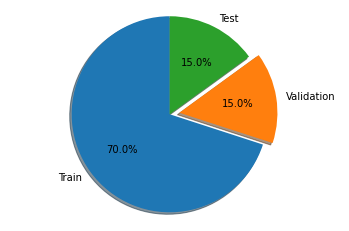

In [ ]:
import matplotlib.pyplot as plt


labels = 'Train', 'Validation', 'Test'
sizes = [n_train, n_valid, n_test]
explode = (0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [ ]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

PREPARAMOS DATALOADER

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True)

In [ ]:
dataloaders_entrenamiento = {"Train":train_loader, "Validation":val_loader}
data_sizes = {x: len(dataloaders_entrenamiento[x].sampler) for x in ['Train','Validation']}

VISUALIZACIÓN DE LOS DATOS

COVID IMAGE:

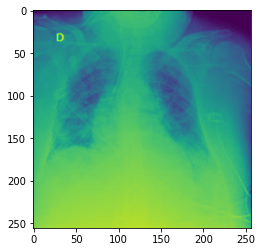

In [ ]:
image = plt.imread('/my_data/COVID/COVID (100).png')
plt.imshow(image)

NORMAL IMAGE:

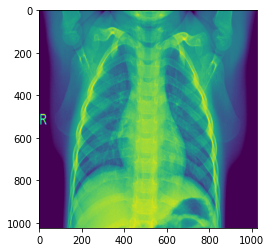

In [ ]:
image = plt.imread('/my_data/NORMAL/NORMAL (1009).png')
plt.imshow(image)

VIRAL PNEUMONIA IMAGE

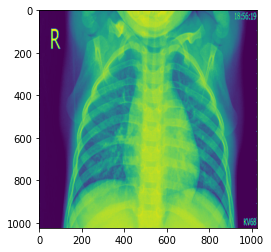

In [ ]:
image = plt.imread('/my_data/Viral Pneumonia/Viral Pneumonia (1030).png')
plt.imshow(image)

In [ ]:
dataset.classes

['COVID', 'NORMAL', 'Viral Pneumonia']

In [ ]:
dataset.class_to_idx

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

**DENSENET**


In [ ]:
resnet50 = torchvision.models.resnet50(pretrained = True)
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
resnet50.fc =nn.Sequential( 
               nn.Linear(2048, 512),
               nn.ReLU(inplace=True),
               nn.Dropout(p=0.5),
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(p=0.3),
               nn.Linear(256, 3)                             # nn.Softmax(dim=1)                                             
                                            )
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.04, momentum = 0.9)

DEFINIMOS LA GRÁFICA DE ENTRENAMIENTO

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val,
                          figsize=(12,6)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(acc_tr)),  100*np.array(acc_tr))
    plt.plot(1+np.arange(len(acc_val)), 100*np.array(acc_val))
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(acc_tr)), np.array(loss_tr))
    plt.plot(1+np.arange(len(acc_val)), np.array(loss_val))
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

ENTRENAMOS EL MODELO

In [ ]:
def train_covid(resnet50, loss_fn, optimizer, epochs=15):
    loss_tr = []
    acc_tr  = []
    loss_val = []
    acc_val = []
    since = time.time()
    best_loss = np.inf
    best_model_wts = copy.deepcopy(resnet50.state_dict())

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 15)

        # Cada epoch tendrá una fase de train y otra de validación
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                resnet50.train()  # Train
            else:
                resnet50.eval()   # Validación

            current_loss = 0.0
            current_acc = 0
            

            #Cogemos los inputs y los almacenamos en un dataloader filtrado por Train y Validation, para poder entrenarlos simultáneamente
            for inputs, labels in tqdm.tqdm(dataloaders_entrenamiento[phase], desc=phase, leave=False):

                #Hacemos 0 los parámetros del gradiente.
                optimizer.zero_grad()

                # BACKWARD PROPAGATION. Se calculan gradientes y se actualizan los pesos
                #Solo se hace el back propagation y se optimiza si es en Train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = resnet50(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # Solo hacemos el backward y optimizamos en train
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                 # Acumulamos las estadísticas de loss y accuracy en variables
                current_loss += loss.item() * inputs.size(0)
                current_acc += torch.sum(preds == labels.data)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_acc.double() / data_sizes[phase]
            if phase == 'Validation':
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_tr.append(epoch_loss)
                acc_tr.append(epoch_acc)
               

            
            if phase == 'Validation' and epoch_loss < best_loss:
                print('Validation loss decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss 
                best_model_wts = copy.deepcopy(resnet50.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    
    grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val)
    return resnet50

Epoch 1/15
---------------


Train Loss: 0.5780 | Train Accuracy: 0.7219


Validation Loss: 1.7856 | Validation Accuracy: 0.6916
Validation loss decreased from inf to 1.7856 
Saving Weights... 

Epoch 2/15
---------------


Train Loss: 0.2442 | Train Accuracy: 0.9241


Validation Loss: 0.2902 | Validation Accuracy: 0.9383
Validation loss decreased from 1.7856 to 0.2902 
Saving Weights... 

Epoch 3/15
---------------


Train Loss: 0.1243 | Train Accuracy: 0.9589


Validation Loss: 0.1446 | Validation Accuracy: 0.9488
Validation loss decreased from 0.2902 to 0.1446 
Saving Weights... 

Epoch 4/15
---------------


Train Loss: 0.0701 | Train Accuracy: 0.9758


Validation Loss: 0.3418 | Validation Accuracy: 0.9147

Epoch 5/15
---------------


Train Loss: 0.0868 | Train Accuracy: 0.9727


Validation Loss: 0.0609 | Validation Accuracy: 0.9790
Validation loss decreased from 0.1446 to 0.0609 
Saving Weights... 

Epoch 6/15
---------------


Train Loss: 0.0504 | Train Accuracy: 0.9837


Validation Loss: 0.3254 | Validation Accuracy: 0.9134

Epoch 7/15
---------------


Train Loss: 0.0463 | Train Accuracy: 0.9837


Validation Loss: 0.1477 | Validation Accuracy: 0.9514

Epoch 8/15
---------------


Train Loss: 0.0202 | Train Accuracy: 0.9924


Validation Loss: 0.0558 | Validation Accuracy: 0.9843
Validation loss decreased from 0.0609 to 0.0558 
Saving Weights... 

Epoch 9/15
---------------


Train Loss: 0.0321 | Train Accuracy: 0.9890


Validation Loss: 0.0795 | Validation Accuracy: 0.9738

Epoch 10/15
---------------


Train Loss: 0.0283 | Train Accuracy: 0.9902


Validation Loss: 0.0680 | Validation Accuracy: 0.9777

Epoch 11/15
---------------


Train Loss: 0.0164 | Train Accuracy: 0.9955


Validation Loss: 0.0438 | Validation Accuracy: 0.9895
Validation loss decreased from 0.0558 to 0.0438 
Saving Weights... 

Epoch 12/15
---------------


Train Loss: 0.0185 | Train Accuracy: 0.9930


Validation Loss: 0.0365 | Validation Accuracy: 0.9856
Validation loss decreased from 0.0438 to 0.0365 
Saving Weights... 

Epoch 13/15
---------------


Train Loss: 0.0121 | Train Accuracy: 0.9958


Validation Loss: 0.0316 | Validation Accuracy: 0.9908
Validation loss decreased from 0.0365 to 0.0316 
Saving Weights... 

Epoch 14/15
---------------


Train Loss: 0.0195 | Train Accuracy: 0.9933


Validation Loss: 0.1927 | Validation Accuracy: 0.9501

Epoch 15/15
---------------


Train Loss: 0.0313 | Train Accuracy: 0.9916


Validation Loss: 0.0737 | Validation Accuracy: 0.9790

Training complete in 325m 11s
Best val loss: 0.0316


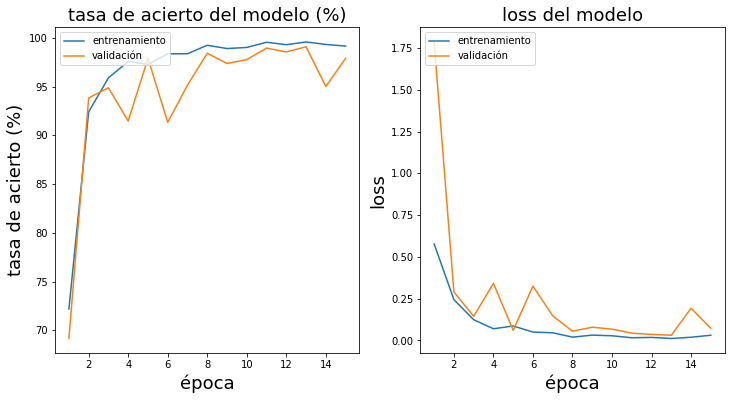

In [ ]:
base_model = train_covid(resnet50, loss_fn, optimizer, epochs=15)

RESULTADOS OBTENIDOS

In [ ]:
resnet50.eval()
correct = 0
total = 0
y_pred = []
y_real = []
with torch.no_grad():
  for data in test_loader:
    #inputs para la evaluación
    images, labels = data
    outputs = resnet50(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    #Para calcular las correctas encuentra la suma cuando las etiquetas son iguales a las predecidas calculadas anteriormente
    correct += (predicted == labels).sum().item()
    y_pred.extend(predicted.numpy().tolist())
    y_real.extend(labels.numpy().tolist())
    #y_pred.extend(predicted.numpy().tolist())
#Dividimos correctas entre totales para calcular la precisión
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the test images: 98 %


(array([351.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0., 211.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

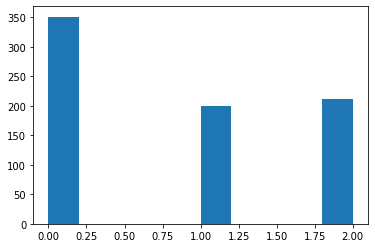

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_pred)


CLASSIFICATION REPORT

In [ ]:
print(classification_report(y_pred, y_real))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       351
           1       0.97      0.97      0.97       200
           2       0.97      0.99      0.98       211

    accuracy                           0.98       762
   macro avg       0.98      0.98      0.98       762
weighted avg       0.98      0.98      0.98       762



In [ ]:
print(y_real)

[2, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1, 0, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 0, 1, 2, 2, 

In [ ]:
print(y_pred)

[2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 2, 2, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 

MATRIZ DE CONFUSIÓN

In [ ]:

conf_matrix= confusion_matrix(y_pred, y_real)

In [ ]:
dataset_indices=dataset.class_to_idx
import seaborn as sn

In [ ]:
print(dataset_indices)

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [ ]:
conf_matrix = pd.DataFrame(conf_matrix, columns=['COVID', 'NORMAL', 'PNEUMONIA'], index=dataset_indices)
conf_matrix


,COVID,NORMAL,PNEUMONIA
COVID,345,4,2
NORMAL,1,194,5
Viral Pneumonia,0,3,208


[Text(32.99999999999999, 0.5, 'True label'),
 Text(0.5, 15.0, 'Predicted label')]

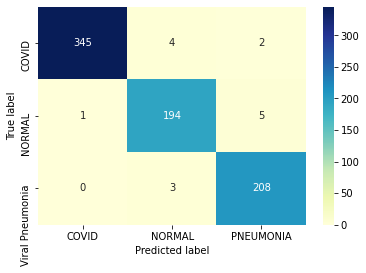

In [ ]:
conf_matrix2 = pd.DataFrame(conf_matrix, columns=['COVID', 'NORMAL', 'PNEUMONIA'], index=dataset_indices)
ax = sn.heatmap(conf_matrix2, annot=True, cmap='YlGnBu', fmt='g')
ax.set(xlabel='Predicted label', ylabel='True label')

VISUALIZACIÓN DE LAS PREDICCIONES

In [ ]:
n_train = 4955
n_valid = 109
n_test = 16

In [ ]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

In [ ]:
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True)

In [ ]:
class_names=dataset.classes
def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))

    for i, image in enumerate(images): 
        plt.subplot(4,4,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'Actual : {class_names[int(labels[i].numpy())]}/ Predicted: {class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

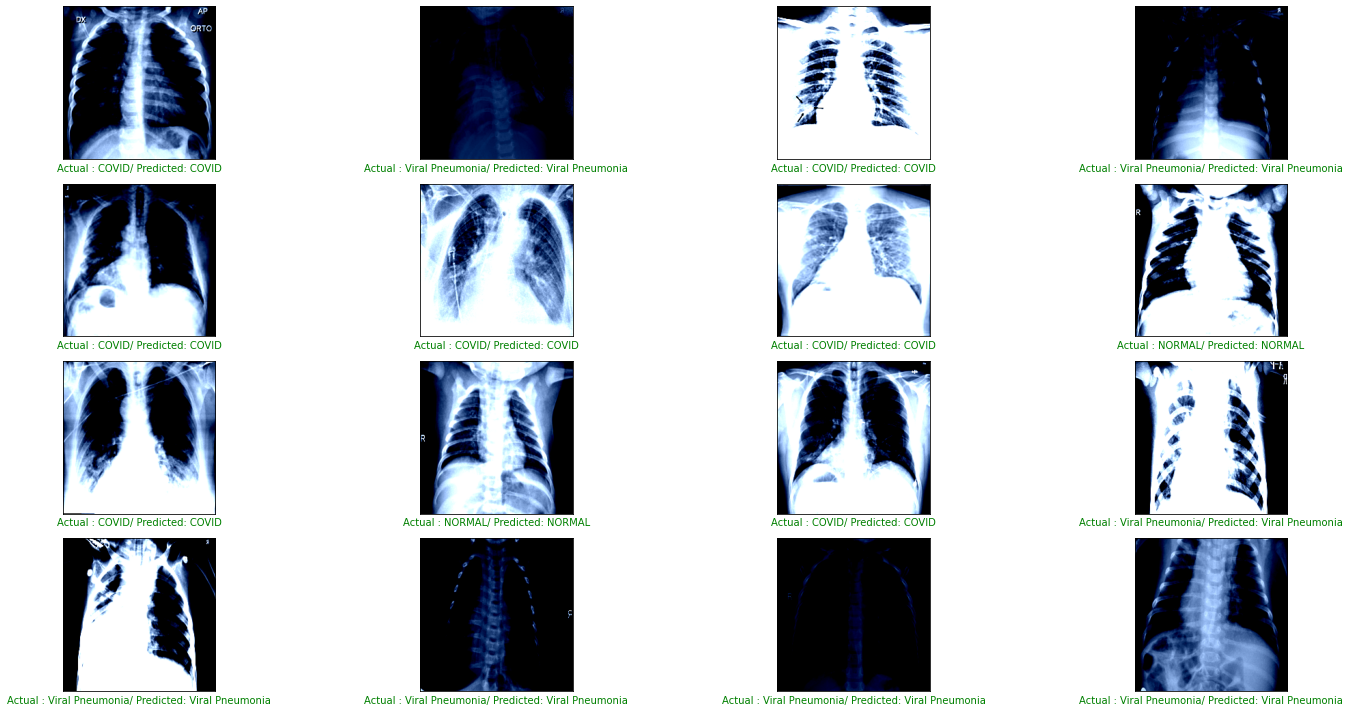

In [ ]:
def show_preds() :
  resnet50.eval()
  images, labels = next(iter(test_loader))
  outputs = resnet50(images)
  _, preds = torch.max(outputs, 1)
  show_images(images, labels, preds)
show_preds()